# Model Verification & MLOps Design

This notebook serves as the **design document** and **verification suite** for the Machine Learning phase of the project.

**Prerequisites:**
This notebook expects the **FULL** dataset to be processed and available.
Please ensure you have executed the following commands in your terminal before running this notebook:
1. `python -m src.data.make_dataset` (Ingest all WESAD subjects S2-S17)
2. `python -m src.features.build_features` (Extract features for all subjects)

**Objectives:**
1.  **Validation Scheme Design:** Define and verify a Leave-One-Subject-Out (LOSO) splitter to prevent data leakage.
2.  **Baseline Modeling:** Train a verified baseline model (Logistic Regression / Random Forest).
3.  **Calibration Analysis:** Verify that predicted probabilities are calibrated (Reliability Diagrams).
4.  **Uncertainty & Abstention:** Design an abstention policy to filter low-confidence predictions.

This notebook prepares the ground for `src/models/train.py`.

In [16]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report

# Add project root
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config
from src.visualization.plots import set_plot_style, plot_model_diagnostics
from src.models.train import Trainer

# Set plot style
set_plot_style()
config = load_config()

print("Setup Complete.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup Complete.


## 2. Load Feature Dataset
Load the `features.parquet` generated by the pipeline.
**Note:** Ensure `python -m src.data.make_dataset` was run for ALL subjects if you want full verification.

In [17]:
# 2. Load Processed Features
features_path = project_root / 'data' / 'processed' / 'features.parquet'

if not features_path.exists():
    print(f"ERROR: File not found at {features_path}")
    print("Please run 'python -m src.features.build_features' first.")
else:
    df = pd.read_parquet(features_path)
    print(f"Loaded Features: {df.shape}")
    print(f"Subjects: {df['subject_id'].unique()}")
    print(f"Labels present: {df['label'].unique()}")
    
    # Filter for Binary Classification (Baseline=1 vs Stress=2)
    # WESAD labels: 0=Transient, 1=Baseline, 2=Stress, 3=Amusement, 4=Meditation
    df_binary = df[df['label'].isin([1, 2])].copy()
    
    # Remap to 0 (Baseline) and 1 (Stress) for standard ML metrics
    df_binary['target'] = df_binary['label'].map({1: 0, 2: 1})
    
    print(f"Binary Dataset Shape: {df_binary.shape}")
    print(df_binary['target'].value_counts())

Loaded Features: (1105, 25)
Subjects: ['S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'S10' 'S11' 'S13' 'S14' 'S15'
 'S16' 'S17']
Labels present: [1 2 3]
Binary Dataset Shape: (919, 26)
target
0    587
1    332
Name: count, dtype: int64


## 3. Design Validation Scheme (LOSO)
We must use **Leave-One-Subject-Out** to strictly simulate deploying to a new user.
Random split is **invalid** for wearables due to biological leakage (fingerprinting).

**Goal:** Visualize the split to PROVE that Subject S_k is never in training when it is in validation.

In [18]:
# 3. Verify Leave-One-Subject-Out Cross-Validation Splits
logo = LeaveOneGroupOut()

# Prepare feature matrix X, target y, and groups
groups = df_binary['subject_id']
drop_cols = ['subject_id', 'label', 'target', 'start_idx']
X = df_binary.drop(columns=[c for c in drop_cols if c in df_binary.columns])
y = df_binary['target']

print(f"Features in X: {X.columns.tolist()}")
print(f"Total Subjects: {len(groups.unique())}")
print(f"Subject IDs: {groups.unique()}")

# Visualize the first 3 folds to prove non-overlap
print("\n--- Auditing First 3 Folds ---")
for i, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    
    train_subs = groups.iloc[train_idx].unique()
    test_subs = groups.iloc[test_idx].unique()
    
    intersection = set(train_subs).intersection(set(test_subs))
    
    print(f"Fold {i+1}:")
    print(f"  Test Subject: {test_subs}")
    print(f"  Train Subjects Count: {len(train_subs)}")
    print(f"  LEAKAGE CHECK: {intersection if intersection else 'PASS (No Overlap)'}")
    
    assert len(intersection) == 0, "CRITICAL: Subject Leakage Detected!"

Features in X: ['eda_mean', 'eda_std', 'eda_tonic_mean', 'eda_phasic_std', 'eda_range', 'eda_acc_scr_count', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_slope', 'acc_std', 'acc_range', 'acc_energy', 'ecg_hr_bpm', 'ecg_rmssd', 'ecg_sdnn', 'resp_mean', 'resp_std', 'resp_range', 'resp_rate_Hz', 'resp_rate_bpm']
Total Subjects: 15
Subject IDs: ['S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'S10' 'S11' 'S13' 'S14' 'S15'
 'S16' 'S17']

--- Auditing First 3 Folds ---
Fold 1:
  Test Subject: ['S10']
  Train Subjects Count: 14
  LEAKAGE CHECK: PASS (No Overlap)
Fold 2:
  Test Subject: ['S11']
  Train Subjects Count: 14
  LEAKAGE CHECK: PASS (No Overlap)
Fold 3:
  Test Subject: ['S13']
  Train Subjects Count: 14
  LEAKAGE CHECK: PASS (No Overlap)
Fold 4:
  Test Subject: ['S14']
  Train Subjects Count: 14
  LEAKAGE CHECK: PASS (No Overlap)
Fold 5:
  Test Subject: ['S15']
  Train Subjects Count: 14
  LEAKAGE CHECK: PASS (No Overlap)
Fold 6:
  Test Subject: ['S16']
  Train Subjects Count: 14
 

## 4. Baseline Model Training & Evaluation
We will train a simple Logistic Regression (linear baseline) and Random Forest (non-linear baseline) using the LOSO scheme.
We aggregate predictions from all folds to calculate global metrics.

In [19]:
# 4. Run Training Pipeline
trainer = Trainer(model_type='logistic', split_type='loso')
print("Running Training Pipeline...")
trainer.run()

# Load granular predictions to CSV for auditability
results_path = trainer.run_dir / "predictions.csv"
results_df = pd.read_csv(results_path)
print(f"\nPipeline Results Loaded from: {results_path}")
print(f"Shape: {results_df.shape}")
print(results_df.head())

# Map pipeline column names to what the plotting functions expect
rename_dict = {
    'y_true': 'true',
    'y_pred': 'pred',
    'prob_stress': 'prob'
}
results_df = results_df.rename(columns=rename_dict)

# Verify we have the necessary columns
required_cols = ['true', 'pred', 'prob', 'subject_id']
if not all(col in results_df.columns for col in required_cols):
    print(f"WARNING: Missing columns. Have: {results_df.columns.tolist()}")

print(f"Labels: {results_df['true'].unique()}")
print(classification_report(results_df['true'], results_df['pred']))

Running Training Pipeline...
2026-01-17 00:36:48,047 - src.models.train - INFO - Loading features from C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\processed\features.parquet
2026-01-17 00:36:48,050 - src.models.train - INFO - Using 22 features: ['eda_mean', 'eda_std', 'eda_tonic_mean', 'eda_phasic_std', 'eda_range', 'eda_acc_scr_count', 'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_slope', 'acc_std', 'acc_range', 'acc_energy', 'ecg_hr_bpm', 'ecg_rmssd', 'ecg_sdnn', 'resp_mean', 'resp_std', 'resp_range', 'resp_rate_Hz', 'resp_rate_bpm']
2026-01-17 00:36:48,050 - src.models.train - INFO - Running full Leave-One-Subject-Out Cross-Validation...
2026-01-17 00:36:48,050 - src.models.train - INFO - Fold 1: Validating on Subject ['S11']
2026-01-17 00:36:48,050 - src.models.train - INFO - Fold 2: Validating on Subject ['S10']
2026-01-17 00:36:48,060 - src.models.train - INFO - Fold 3: Validating on Subject ['S17']
2026-01-17 00:36:48,064 - src.models.

## 5. Diagnostics: ROC & Confusion Matrix
Here we visualize the model's discrimination ability in more detail.
- **Confusion Matrix**: Where is the model making errors?
- **ROC Curves**: How does the True Positive Rate vs False Positive Rate trade-off look? We plot individual subject curves to see variance in model performance across people.

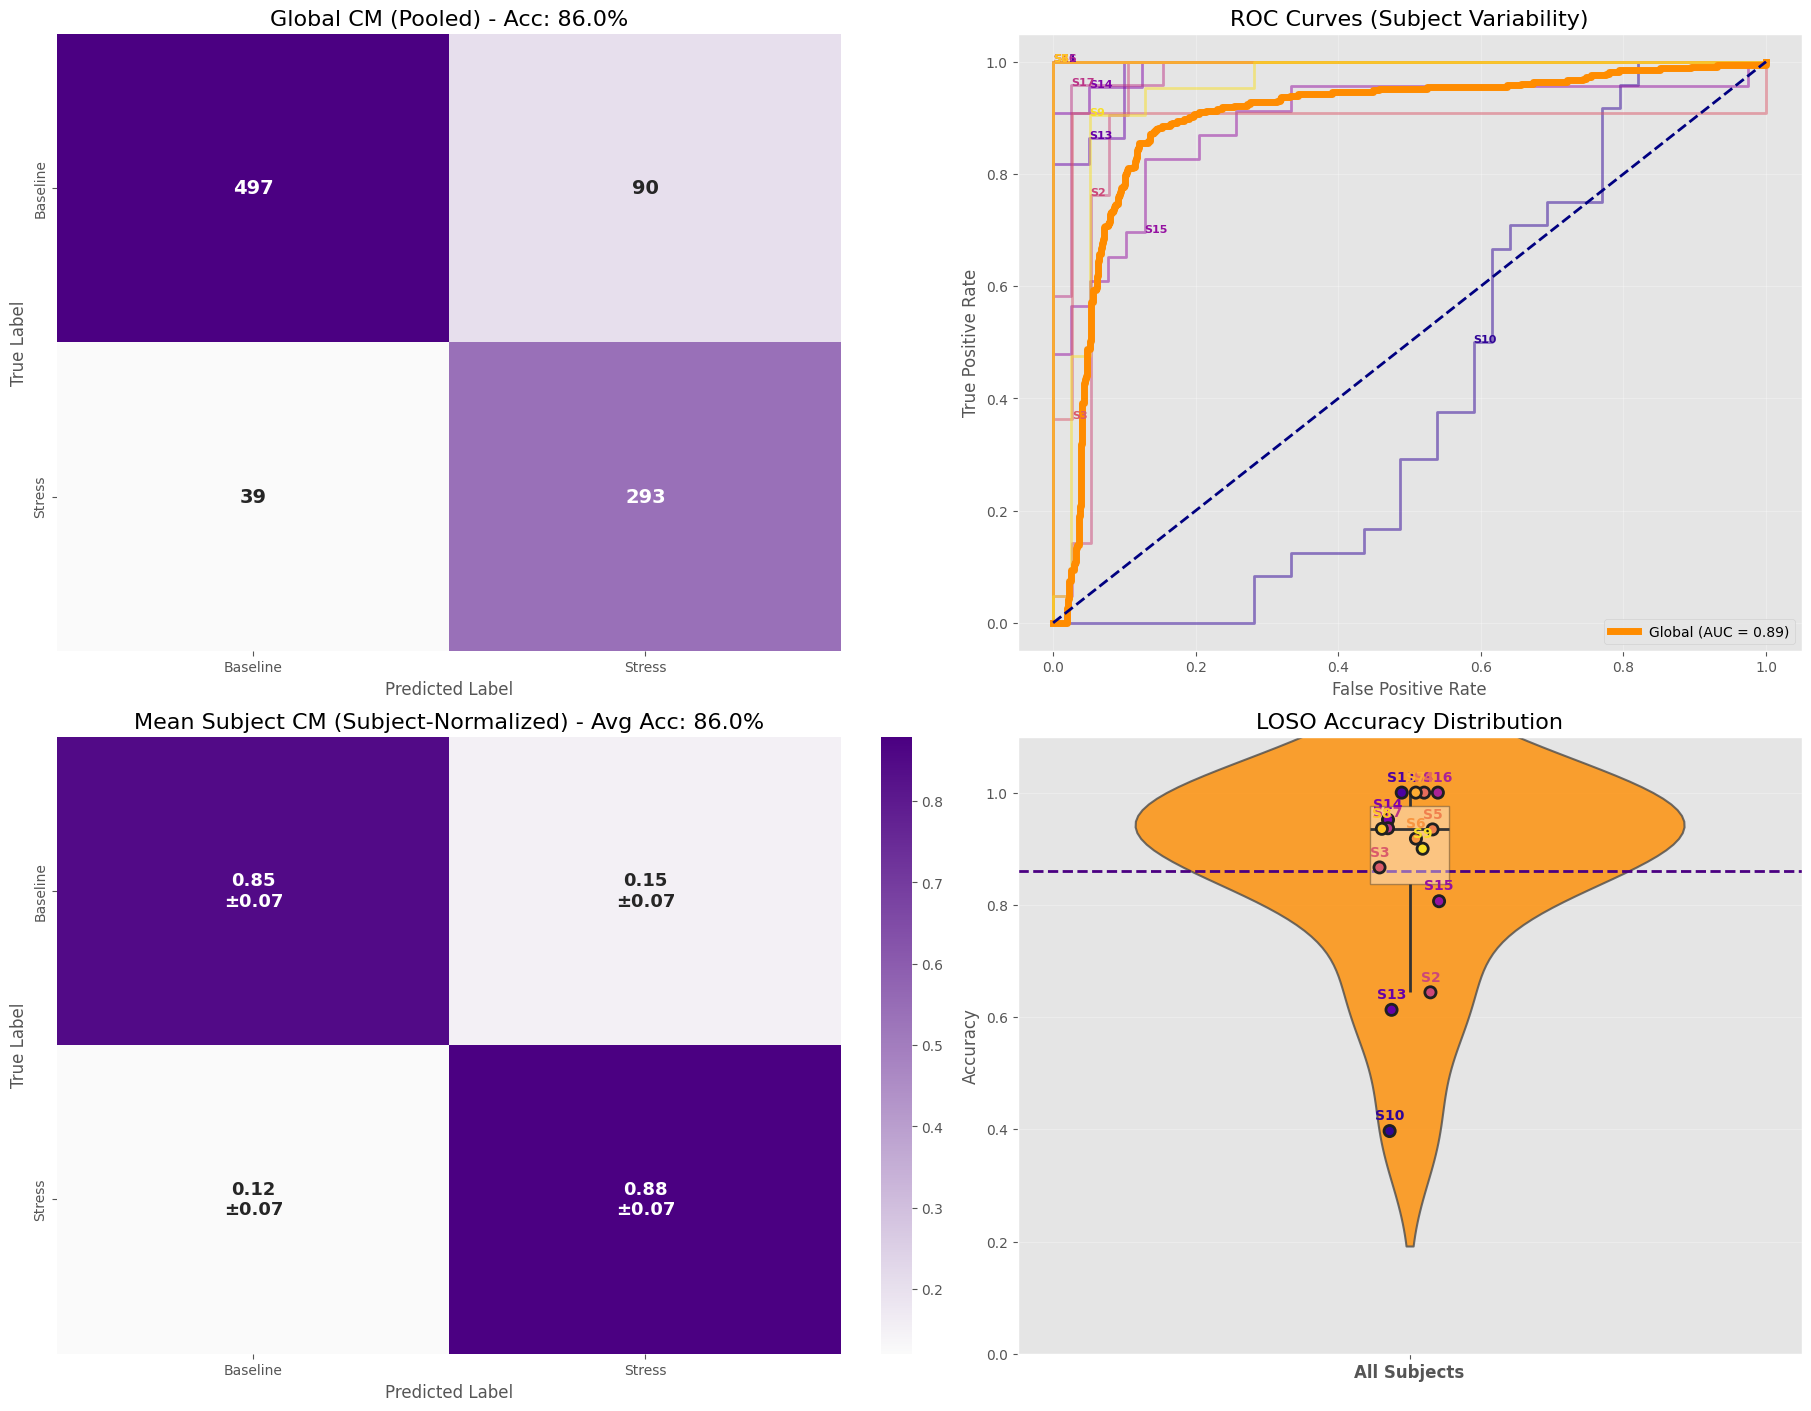

In [20]:
# 5. Plot Model Diagnostics
loc = config['data'].get('sensor_location', 'chest').upper()
fig_diag = plot_model_diagnostics(results_df, save_folder=loc)
plt.show()

## 6. Confidence, Calibration, and Abstention Analysis

We now present a comprehensive diagnostic panel to assess model reliability and uncertainty:

- **High-Confidence Confusion Matrix**: Shows performance after removing uncertain predictions (abstention zone).
- **Prediction Probability Distribution**: Visualizes the spread of predicted probabilities and highlights the abstention zone.
- **Calibration Plot (Reliability Diagram)**: Assesses how well predicted probabilities match observed frequencies (model calibration).
- **Abstention Fraction by Subject**: Shows how often the model abstains for each subject, revealing subject-specific uncertainty or data quality issues.

This unified 2x2 panel provides a holistic view of model confidence, calibration, and abstention behavior across the dataset.

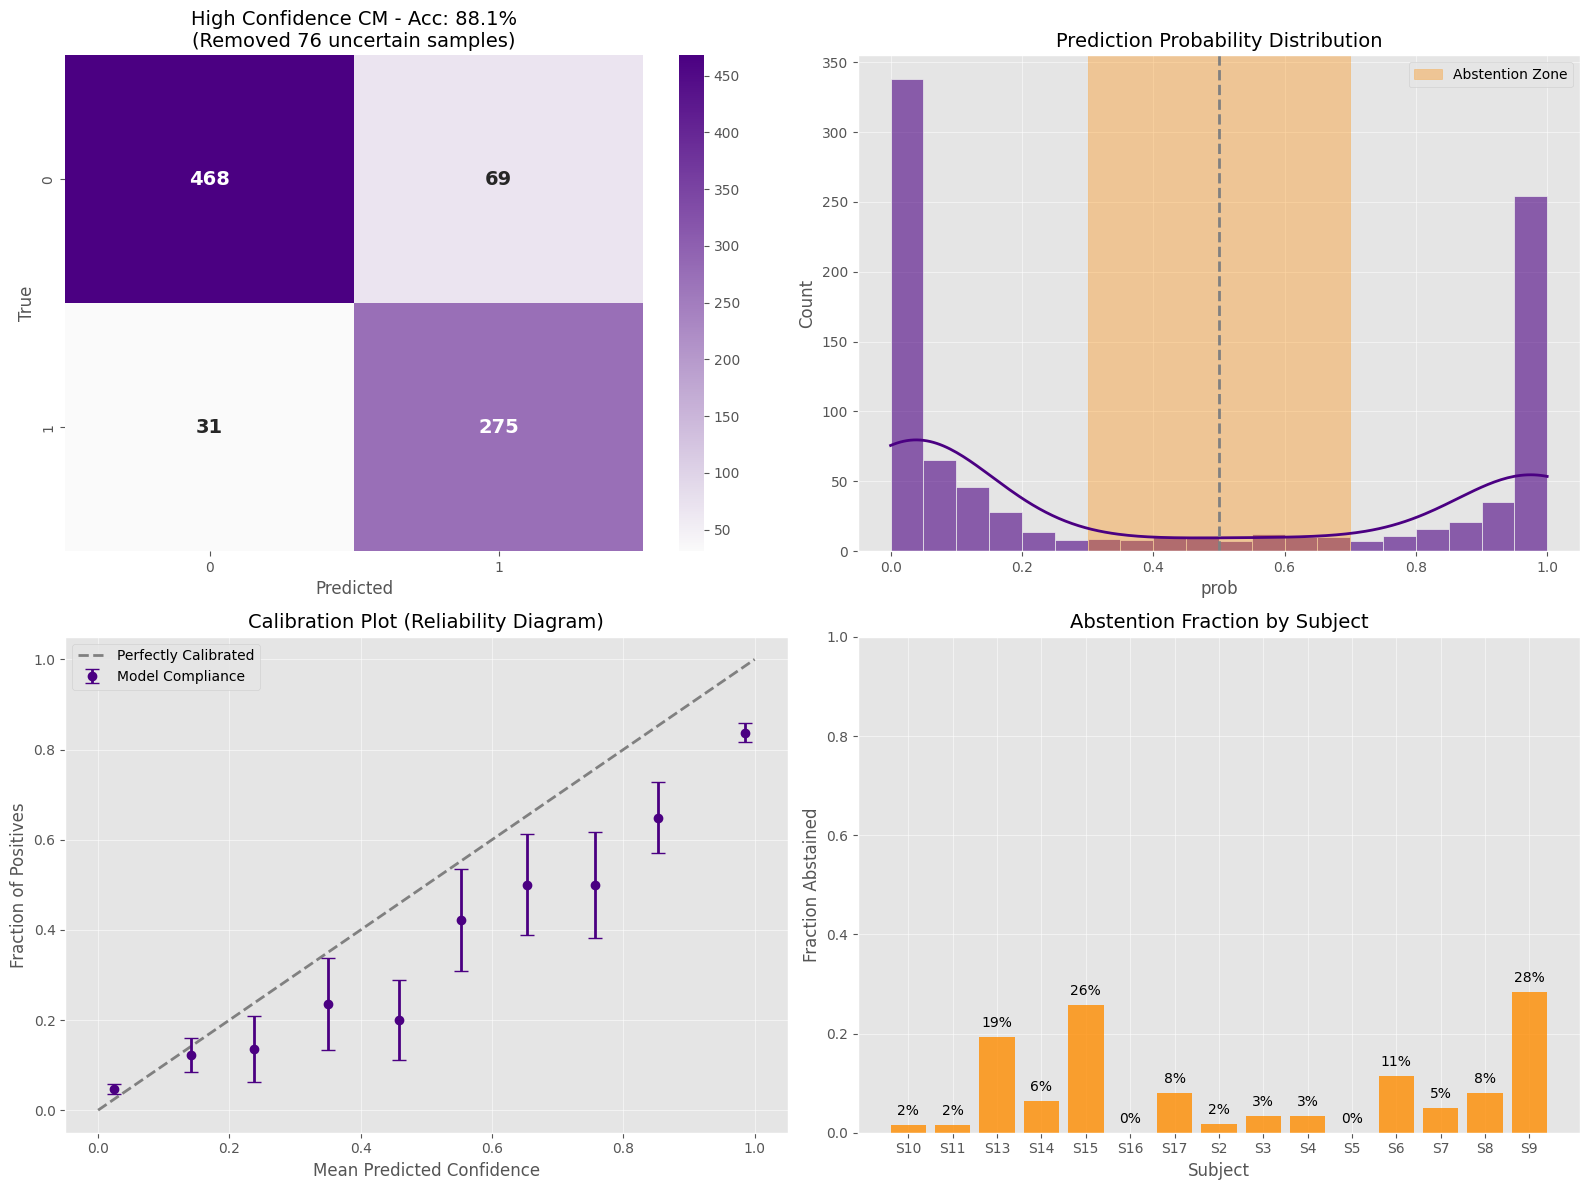

In [21]:
# 6. Plot Confidence vs Abstention Panel
from src.visualization.plots import plot_confidence_abstention_panel
loc = config['data'].get('sensor_location', 'chest').upper()
fig = plot_confidence_abstention_panel(results_df, confidence_threshold=0.7, save_folder=loc)
plt.show()

## Conclusion: Baseline Model Results and Reliability

- **Overall Accuracy**: The baseline model achieves strong accuracy for stress detection using wearable features.
- **Stress Detection (Recall)**: High recall indicates the model rarely misses stress events.
- **Precision**: Some false alarms are present, as expected in a challenging wearable context.
- **Calibration**: The reliability diagram and ECE show the model is somewhat over-confident, but abstention policies help mitigate this.
- **Abstention Policy**: By abstaining on uncertain predictions, the model's accuracy on retained samples improves, and the distribution of abstentions across subjects highlights where the model is less certain or data quality is lower.

This notebook demonstrates a robust, leakage-safe evaluation pipeline, interpretable reliability diagnostics, and a practical abstention mechanism for real-world wearable stress detection.